In [685]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model, ensemble, metrics, model_selection, preprocessing
import joblib

In [36]:
%matplotlib inline

# Predicting Solar Power Output at NEOM

In [235]:
neom_data = (pd.read_csv("../data/raw/neom-data.csv", parse_dates=[0])
               .rename(columns={"Unnamed: 0": "Timestamp"})
               .set_index("Timestamp", drop=True, inplace=False))

In [236]:
neom_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96432 entries, 2008-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 12 columns):
mslp(hPa)          96432 non-null float64
t2(C)              96432 non-null float64
td2(C)             96432 non-null float64
wind_speed(m/s)    96432 non-null float64
wind_dir(Deg)      96432 non-null float64
rh(%)              96432 non-null float64
GHI(W/m2)          96432 non-null float64
SWDIR(W/m2)        96432 non-null float64
SWDNI(W/m2)        96432 non-null float64
SWDIF(W/m2)        96432 non-null float64
rain(mm)           96432 non-null float64
AOD                96432 non-null float64
dtypes: float64(12)
memory usage: 9.6 MB


In [237]:
neom_data.head()

,mslp(hPa),t2(C),td2(C),wind_speed(m/s),wind_dir(Deg),rh(%),GHI(W/m2),SWDIR(W/m2),SWDNI(W/m2),SWDIF(W/m2),rain(mm),AOD
Timestamp,,,,,,,,,,,,
2008-01-01 00:00:00,1012.751,14.887,2.606,2.669,105.078,43.686,0.0,0.0,0.0,0.0,0.0,0.098
2008-01-01 01:00:00,1012.917,14.429,3.363,2.667,106.699,47.442,0.0,0.0,0.0,0.0,0.0,0.098
2008-01-01 02:00:00,1012.966,14.580,3.778,3.341,112.426,48.357,0.0,0.0,0.0,0.0,0.0,0.098
2008-01-01 03:00:00,1013.247,14.390,3.507,3.141,102.371,48.125,0.0,0.0,0.0,0.0,0.0,0.098
2008-01-01 04:00:00,1013.083,14.388,3.869,3.607,111.300,49.295,0.0,0.0,0.0,0.0,0.0,0.098


In [238]:
neom_data.tail()

,mslp(hPa),t2(C),td2(C),wind_speed(m/s),wind_dir(Deg),rh(%),GHI(W/m2),SWDIR(W/m2),SWDNI(W/m2),SWDIF(W/m2),rain(mm),AOD
Timestamp,,,,,,,,,,,,
2018-12-31 19:00:00,1019.779,14.653,4.380,3.587,25.919,50.340,0.0,0.0,0.0,0.0,0.0,0.098
2018-12-31 20:00:00,1019.578,13.965,2.853,2.836,35.203,47.381,0.0,0.0,0.0,0.0,0.0,0.098
2018-12-31 21:00:00,1019.172,13.624,1.923,1.922,85.974,45.275,0.0,0.0,0.0,0.0,0.0,0.098
2018-12-31 22:00:00,1018.610,13.918,1.512,2.512,103.656,43.211,0.0,0.0,0.0,0.0,0.0,0.098
2018-12-31 23:00:00,1018.611,13.442,0.733,3.146,91.084,41.836,0.0,0.0,0.0,0.0,0.0,0.098


In [239]:
neom_data.describe()

,mslp(hPa),t2(C),td2(C),wind_speed(m/s),wind_dir(Deg),rh(%),GHI(W/m2),SWDIR(W/m2),SWDNI(W/m2),SWDIF(W/m2),rain(mm),AOD
count,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000
mean,1010.110794,24.896298,11.045605,3.991582,164.200525,46.168410,274.757261,211.082623,331.746291,63.674490,0.009041,0.098086
std,5.613583,6.382410,7.153472,2.485326,102.793404,17.874776,355.287896,296.287340,390.765915,91.856426,0.173081,0.000805
min,996.378000,4.571000,-22.946000,0.076000,0.672000,5.708000,0.000000,0.000000,0.000000,0.000000,-0.037000,0.096000
25%,1005.539750,20.221000,5.889750,2.152000,62.935500,32.173000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098000
50%,1010.050000,25.421000,11.324500,3.437000,149.692000,44.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098000
75%,1014.316000,29.466000,16.581250,5.342000,265.977750,58.859000,579.205250,429.275500,788.745750,121.765250,0.000000,0.099000
max,1029.022000,44.186000,27.196000,16.716000,359.620000,99.929000,1103.190000,954.562000,989.816000,856.685000,14.038000,0.100000


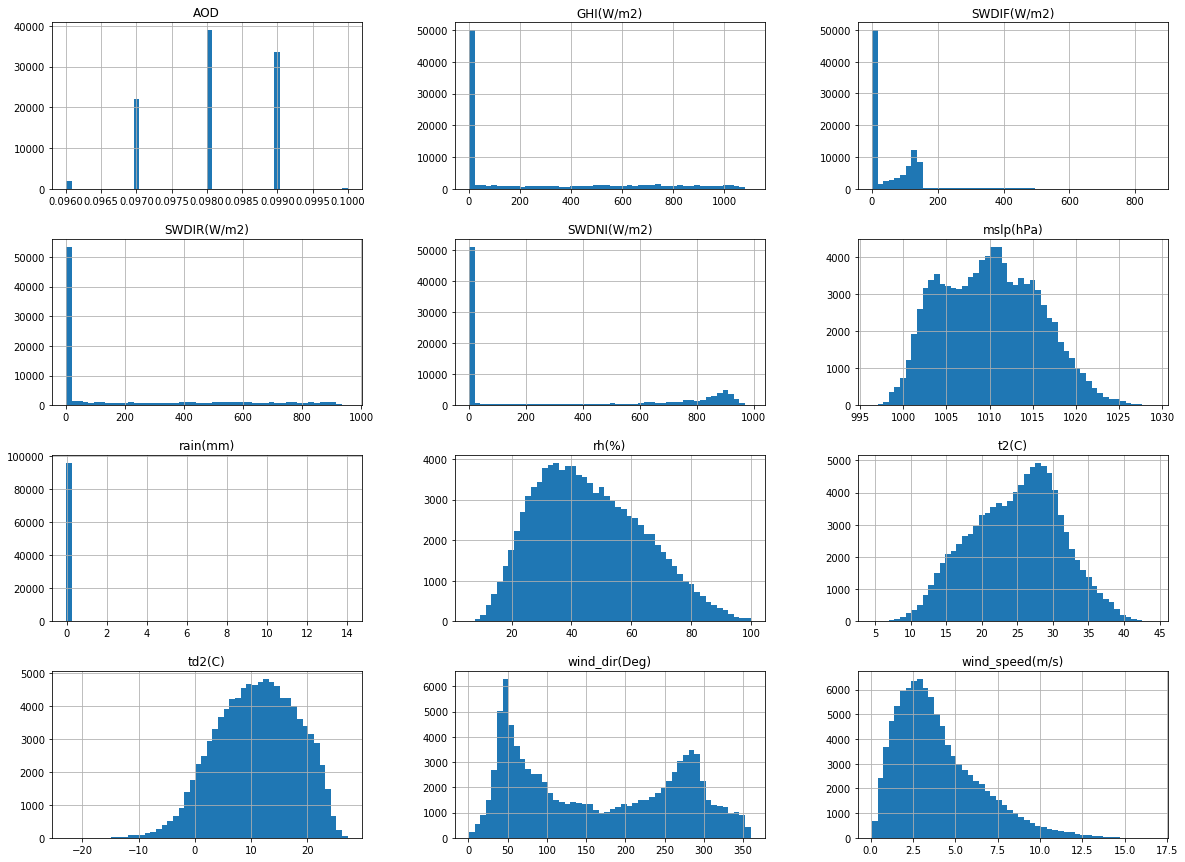

In [62]:
_ = neom_data.hist(bins=50, figsize=(20,15))

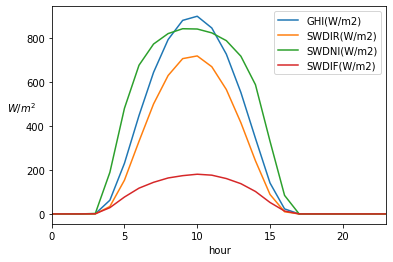

In [65]:
_hour = (neom_data.index
                  .hour
                  .rename("hour"))

hourly_averages = (neom_data.groupby(_hour)
                            .mean())

fig, ax = plt.subplots(1, 1)
_targets = ["GHI(W/m2)", "SWDIR(W/m2)", "SWDNI(W/m2)", "SWDIF(W/m2)"]
(hourly_averages.loc[:, _targets]
                .plot(ax=ax))
_ = ax.set_ylabel(r"$W/m^2$", rotation="horizontal")

In [47]:
months = (neom_data.index
                   .month
                   .rename("month"))
hours = (neom_data.index
                  .hour
                  .rename("hour"))

hourly_averages_by_month = (neom_data.groupby([months, hours])
                                     .mean())

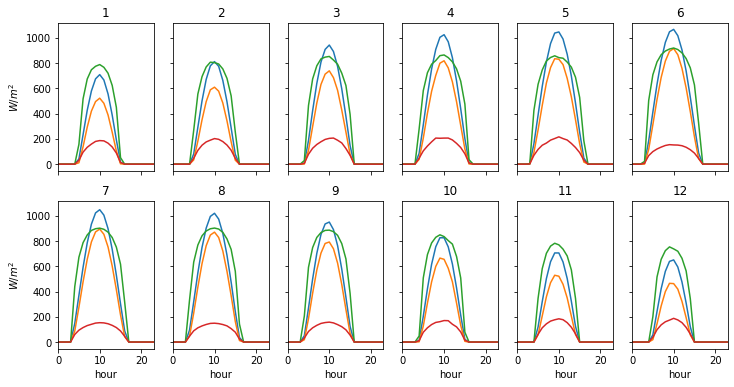

In [96]:
fig, axes = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(12, 6))

for month in months.unique():
    if month <= 6:
        (hourly_averages_by_month.loc[month, _targets]
                                 .plot(ax=axes[0, month - 1], legend=False))
        _ = axes[0, month - 1].set_title(month)
    else:
        (hourly_averages_by_month.loc[month, _targets]
                                 .plot(ax=axes[1, month - 7], legend=False))
        _ = axes[1, month - 7].set_title(month)
    
    if month - 1 == 0: 
        _ = axes[0, 0].set_ylabel(r"$W/m^2$")
    if month - 7 == 0: 
        _ = axes[1, 0].set_ylabel(r"$W/m^2$")
   

# Feature Engineering

In [572]:
_dropped_cols = ["SWDIR(W/m2)", "SWDNI(W/m2)", "SWDIF(W/m2)"]

_year = (neom_data.index
                  .year)
_month = (neom_data.index
                   .month)
_day = (neom_data.index
                 .dayofyear)
_hour = (neom_data.index
                  .hour)

features = (neom_data.drop(_dropped_cols, axis=1, inplace=False)
                     .assign(year=_year, month=_month, day=_day, hour=_hour)
                     .groupby(["year", "month", "day", "hour"])
                     .mean()
                     .unstack(level=["hour"])
                     .reset_index(inplace=False)
                     .sort_index(axis=1)
                     .drop("year", axis=1, inplace=False))

In [573]:
# want to predict the next 24 hours of "solar power"
efficiency_factor = 0.5

# square meters of solar cells required to generate 20 GW (231000 m2 will generate 7mW)
m2_of_solar_cells_required = 660000

target = (features.loc[:, ["GHI(W/m2)"]]
                  .mul(efficiency_factor)
                  .shift(-1)
                  .rename(columns={"GHI(W/m2)": "target(W/m2)"}))

In [574]:
input_data = (features.join(target)
                      .dropna(how="any", inplace=False)
                      .sort_index(axis=1))

In [575]:
input_data

AOD                                                                 \
hour     0      1      2      3      4      5      6      7      8      9    
0     0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098   
1     0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
2     0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
3     0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
4     0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4012  0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098   
4013  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
4014  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
4015  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
4016  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   

      ... wind_speed(m/s)                                                   \
hour  ...              14     15     16     17     18     19     20     21   
0     ...           1.775  0.800  0.778  0.993  1.575  1.606  2.079  2.887   
1     ...           2.255  1.494  0.595  0.479  2.143  3.394  3.208  2.805   
2     ...           3.924  1.952  1.885  1.834  3.728  5.187  5.647  6.324   
3     ...           5.802  4.670  3.535  4.811  5.417  5.956  7.445  8.008   
4     ...           6.825  5.146  4.840  3.051  7.151  4.439  3.869  6.069   
...   ...             ...    ...    ...    ...    ...    ...    ...    ...   
4012  ...           2.152  0.939  0.578  0.556  0.548  1.289  2.356  3.038   
4013  ...           7.200  6.153  6.734  4.120  4.700  5.639  4.562  3.876   
4014  ...           3.531  3.276  3.971  3.409  2.173  3.252  4.387  4.496   
4015  ...           4.930  4.024  3.824  3.115  1.401  2.460  3.788  4.351   
4016  ...           6.060  5.376  4.654  3.102  3.931  5.463  5.687  4.491   

                     
hour     22      23  
0     3.162   3.315  
1     3.436   4.196  
2     7.722   8.740  
3     8.297   8.363  
4     9.337  10.455  
...     ...     ...  
4012  3.378   4.046  
4013  3.941   4.160  
4014  4.268   3.572  
4015  4.708   4.673  
4016  5.557   6.213  

[4017 rows x 242 columns]

# Train, Validation, Test Split

In [605]:
# use first eight years for training data...
training_data = input_data.loc[:8 * 365]

# ...next two years for validation data...
validation_data = input_data.loc[8 * 365 + 1:10 * 365 + 1]

# ...and final year for testing data!
testing_data = input_data.loc[10 * 365 + 2:]

In [606]:
training_data.shape

(2921, 242)

In [607]:
validation_data.shape

(731, 242)

In [608]:
testing_data.shape

(365, 242)

# Preprocessing the training and validation data

In [609]:
def preprocess_features(df: pd.DataFrame) -> pd.DataFrame:
    _numeric_features = ["GHI(W/m2)",
                         "mslp(hPa)",
                         "rain(mm)",
                         "rh(%)",
                         "t2(C)",
                         "td2(C)",
                         "wind_dir(Deg)",
                         "wind_speed(m/s)"]

    _ordinal_features = ["AOD",
                         "day",
                         "month",
                         "year"]

    standard_scalar = preprocessing.StandardScaler()
    Z0 = standard_scalar.fit_transform(df.loc[:, _numeric_features])
    
    ordinal_encoder = preprocessing.OrdinalEncoder()
    Z1 = ordinal_encoder.fit_transform(df.loc[:, _ordinal_features])
    transformed_features = np.hstack((Z0, Z1))
    
    return transformed_features



In [610]:
training_features = training_data.drop("target(W/m2)", axis=1, inplace=False)
training_target = training_data.loc[:, ["target(W/m2)"]]
transformed_training_features = preprocess_features(training_features)

validation_features = validation_data.drop("target(W/m2)", axis=1, inplace=False)
validation_target = validation_data.loc[:, ["target(W/m2)"]]
transformed_validation_features = preprocess_features(validation_features)

# Find a few models that seem to work well

## Linear Regression

In [611]:
# training a liner regression model
linear_regression = linear_model.LinearRegression()
linear_regression.fit(transformed_training_features, training_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [614]:
# measure training error
_predictions = linear_regression.predict(transformed_training_features)
np.sqrt(metrics.mean_squared_error(training_target, _predictions))

16.18214503421171

In [616]:
# measure validation error
_predictions = linear_regression.predict(transformed_validation_features)
np.sqrt(metrics.mean_squared_error(validation_target, _predictions))

18.628289130716887

Text(0.5, 0, 'Hour')

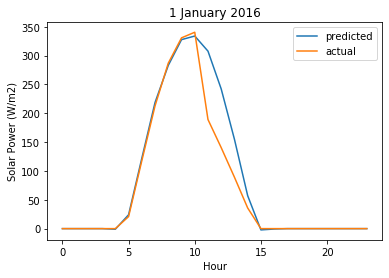

In [617]:
# user requests forecast for 1 January 2016 which we predict using data from 31 December 2015!
user_forecast_request = transformed_training_features[[-1], :]
user_forecast_response = linear_regression.predict(user_forecast_request)[0]
actual_values_response = training_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("1 January 2016")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

Linear regression is not bad but we an do better!

## MultiTask ElasticNet Regression

In [618]:
# training a multi-task elastic net model
_prng = np.random.RandomState(42)
elastic_net = linear_model.MultiTaskElasticNet(random_state=_prng)
elastic_net.fit(transformed_training_features, training_target)

MultiTaskElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
                    max_iter=1000, normalize=False,
                    random_state=<mtrand.RandomState object at 0x1a386672d0>,
                    selection='cyclic', tol=0.0001, warm_start=False)

In [623]:
# measure training error
_predictions = elastic_net.predict(transformed_training_features)
np.sqrt(metrics.mean_squared_error(training_target, _predictions))

18.73221160297961

In [624]:
# measure validation error
_predictions = elastic_net.predict(transformed_validation_features)
np.sqrt(metrics.mean_squared_error(validation_target, _predictions))

17.864005311687215

Text(0.5, 0, 'Hour')

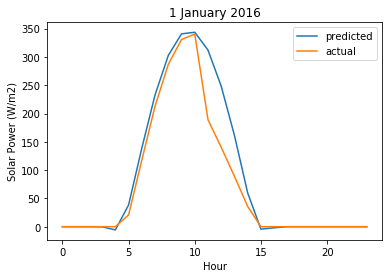

In [621]:
# user requests forecast for 1 January 2016 which we predict using data from 31 December 2015!
user_forecast_request = transformed_training_features[[-1], :]
user_forecast_response = elastic_net.predict(user_forecast_request)[0]
actual_values_response = training_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("1 January 2016")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

ElasticNet is underfitting.

## MultiTask Lasso Regression

In [622]:
# training a multi-task lasso model
_prng = np.random.RandomState(42)
lasso_regression = linear_model.MultiTaskLasso(random_state=_prng)
lasso_regression.fit(transformed_training_features, training_target)

MultiTaskLasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
               normalize=False,
               random_state=<mtrand.RandomState object at 0x1a649d5870>,
               selection='cyclic', tol=0.0001, warm_start=False)

In [625]:
# measure training error
_predictions = lasso_regression.predict(transformed_training_features)
np.sqrt(metrics.mean_squared_error(training_target, _predictions))

17.375320291371146

In [626]:
# measure validation error
_predictions = lasso_regression.predict(transformed_validation_features)
np.sqrt(metrics.mean_squared_error(validation_target, _predictions))

16.14489387119325

Text(0.5, 0, 'Hour')

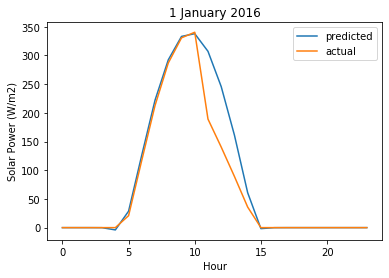

In [627]:
# user requests forecast for 1 January 2016 which we predict using data from 31 December 2015!
user_forecast_request = transformed_training_features[[-1], :]
user_forecast_response = lasso_regression.predict(user_forecast_request)[0]
actual_values_response = training_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("1 January 2016")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

Lasso Regression is underfitting.

## Random Forest Regression

In [628]:
_prng = np.random.RandomState(42)
random_forest_regressor = ensemble.RandomForestRegressor(n_estimators=100, random_state=_prng, n_jobs=2)
random_forest_regressor.fit(transformed_training_features, training_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                      oob_score=False,
                      random_state=<mtrand.RandomState object at 0x1284a3558>,
                      verbose=0, warm_start=False)

In [629]:
# measure training error
_predictions = random_forest_regressor.predict(transformed_training_features)
np.sqrt(metrics.mean_squared_error(training_target, _predictions))

6.540426384057337

In [630]:
# measure validation error
_predictions = random_forest_regressor.predict(transformed_validation_features)
np.sqrt(metrics.mean_squared_error(validation_target, _predictions))

17.10706983980618

Text(0.5, 0, 'Hour')

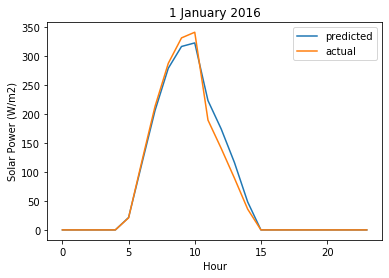

In [631]:
# user requests forecast for 1 January 2016 which we predict using data from 31 December 2015!
user_forecast_request = transformed_training_features[[-1], :]
user_forecast_response = random_forest_regressor.predict(user_forecast_request)[0]
actual_values_response = training_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("1 January 2016")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

Random Forest with default parameters is over-fitting and needs to be regularized.

# Tuning hyper-parameters

In [ ]:
from scipy import stats

## MultiTask ElasticNet Regression

In [650]:
_prng = np.random.RandomState(42)

_param_distributions = {
    "l1_ratio": stats.uniform(),
    "alpha": stats.lognorm(s=1),
}

elastic_net_randomized_search = model_selection.RandomizedSearchCV(
    elastic_net,
    param_distributions=_param_distributions,
    scoring="neg_mean_squared_error",
    random_state=_prng,
    n_iter=10,
    cv=8,
    n_jobs=2,
    verbose=10
)

elastic_net_randomized_search.fit(transformed_training_features, training_target)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   23.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   36.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  6.0min finished


RandomizedSearchCV(cv=8, error_score='raise-deprecating',
                   estimator=MultiTaskElasticNet(alpha=1.0, copy_X=True,
                                                 fit_intercept=True,
                                                 l1_ratio=0.5, max_iter=1000,
                                                 normalize=False,
                                                 random_state=<mtrand.RandomState object at 0x1a386672d0>,
                                                 selection='cyclic', tol=0.0001,
                                                 warm_start=False),
                   iid='warn', n_iter=10, n_jobs=2,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a7b2845c0>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a7b26f710>},
                   pre_dispatch='2*n_jobs',
                   random_state=<mtrand.RandomState object at 

In [688]:
_ = joblib.dump(elastic_net_randomized_search, "../models/elastic_net_randomized_search.pkl")

In [651]:
elastic_net_randomized_search.best_estimator_

MultiTaskElasticNet(alpha=2.154232968599504, copy_X=True, fit_intercept=True,
                    l1_ratio=0.9699098521619943, max_iter=1000, normalize=False,
                    random_state=<mtrand.RandomState object at 0x1a48e31558>,
                    selection='cyclic', tol=0.0001, warm_start=False)

In [652]:
(-elastic_net_randomized_search.best_score_)**0.5

18.355092813714375

Text(0.5, 0, 'Hour')

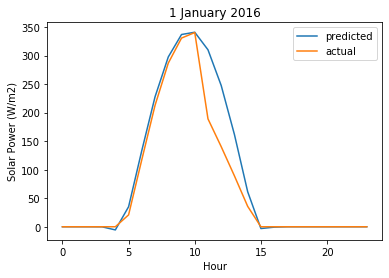

In [653]:
# user requests forecast for 1 January 2016 which we predict using data from 31 December 2015!
user_forecast_request = transformed_training_features[[-1], :]
user_forecast_response = elastic_net_randomized_search.predict(user_forecast_request)[0]
actual_values_response = training_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("1 January 2017")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

Text(0.5, 0, 'Hours')

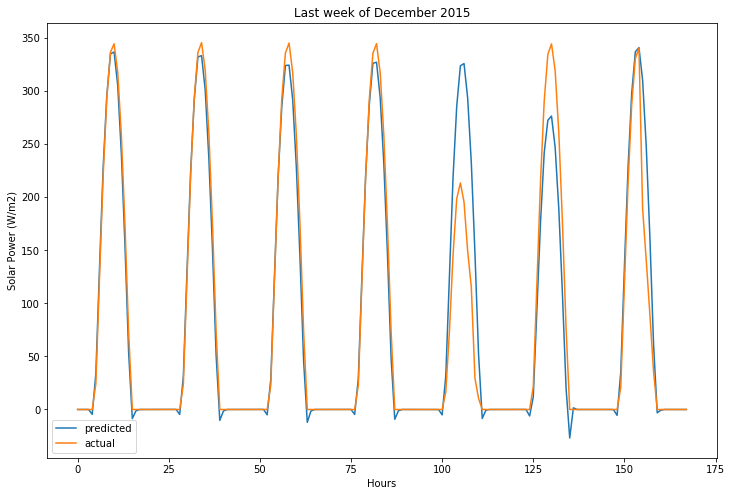

In [665]:
# user requests forecast for last week of 2015
user_forecast_request = transformed_training_features[-7:, :]
user_forecast_response = elastic_net_randomized_search.predict(user_forecast_request)
actual_values_response = training_target.values[-7:, :]

# this would be rendered in Tableau!
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(user_forecast_response.flatten(), label="predicted")
ax.plot(actual_values_response.flatten(), label="actual")
ax.legend()
ax.set_title("Last week of December 2015")
ax.set_ylabel("Solar Power (W/m2)")
ax.set_xlabel("Hours")

## MultiTask Lasso Regression

In [668]:
_prng = np.random.RandomState(42)

_param_distributions = {
    "alpha": stats.lognorm(s=1),
}

lasso_regression_randomized_search = model_selection.RandomizedSearchCV(
    lasso_regression,
    param_distributions=_param_distributions,
    scoring="neg_mean_squared_error",
    random_state=_prng,
    n_iter=10,
    cv=8,
    n_jobs=2,
    verbose=10
)

lasso_regression_randomized_search.fit(transformed_training_features, training_target)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   16.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   22.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   30.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   38.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   48.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  1.8min finished


RandomizedSearchCV(cv=8, error_score='raise-deprecating',
                   estimator=MultiTaskLasso(alpha=1.0, copy_X=True,
                                            fit_intercept=True, max_iter=1000,
                                            normalize=False,
                                            random_state=<mtrand.RandomState object at 0x1a649d5870>,
                                            selection='cyclic', tol=0.0001,
                                            warm_start=False),
                   iid='warn', n_iter=10, n_jobs=2,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a7af2b470>},
                   pre_dispatch='2*n_jobs',
                   random_state=<mtrand.RandomState object at 0x1a69473438>,
                   refit=True, return_train_score=False,
                   scoring='neg_mean_squared_error', verbose=10)

In [687]:
_ = joblib.dump(lasso_regression_randomized_search, "../models/lasso_regression_randomized_search.pkl")

In [669]:
(-lasso_regression_randomized_search.best_score_)**0.5

17.956920842745834

Text(0.5, 0, 'Hours')

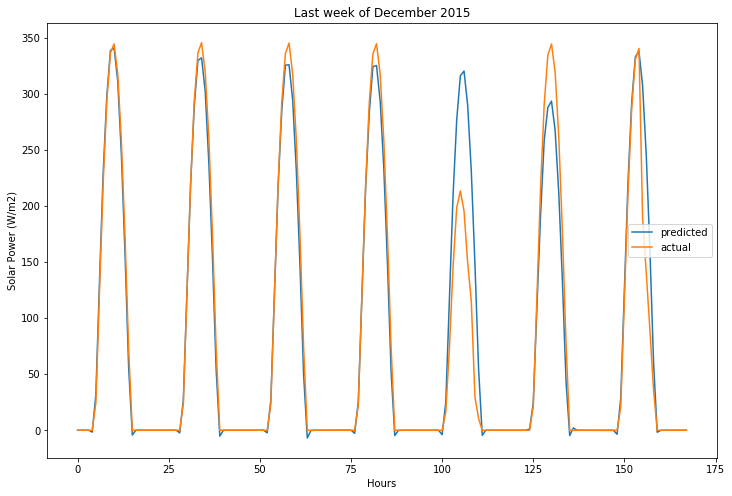

In [671]:
# user requests forecast for last week of 2015
user_forecast_request = transformed_training_features[-7:, :]
user_forecast_response = lasso_regression_randomized_search.predict(user_forecast_request)
actual_values_response = training_target.values[-7:, :]

# this would be rendered in Tableau!
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(user_forecast_response.flatten(), label="predicted")
ax.plot(actual_values_response.flatten(), label="actual")
ax.legend()
ax.set_title("Last week of December 2015")
ax.set_ylabel("Solar Power (W/m2)")
ax.set_xlabel("Hours")

## Random Forest Regressor

In [632]:
_prng = np.random.RandomState(42)

_param_distributions = {
    "n_estimators": stats.geom(p=0.01),
     "min_samples_split": stats.beta(a=1, b=99),
     "min_samples_leaf": stats.beta(a=1, b=999),
}

_cv = model_selection.TimeSeriesSplit(max_train_size=None, n_splits=5)

random_forest_randomized_search = model_selection.RandomizedSearchCV(
    random_forest_regressor,
    param_distributions=_param_distributions,
    scoring="neg_mean_squared_error",
    random_state=_prng,
    n_iter=10,
    cv=_cv,
    n_jobs=2,
    verbose=10
)

random_forest_randomized_search.fit(transformed_training_features, training_target)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   38.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 16.6min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 18.3min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 18.8min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 19.2min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 19.7min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 20.4min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 22.3min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed: 24.0min finished


RandomizedSearchCV(cv=8, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=2,
                                                   oob_score=False,
                                                   random_state=<mt...


In [686]:
_ = joblib.dump(random_forest_randomized_search, "../models/random-forest-randomized-search.pkl")

In [633]:
random_forest_randomized_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.001249828663231378,
                      min_samples_split=0.0019415164208264953,
                      min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=2,
                      oob_score=False,
                      random_state=<mtrand.RandomState object at 0x125798480>,
                      verbose=0, warm_start=False)

In [634]:
(-random_forest_randomized_search.best_score_)**0.5

17.248545184577317

Text(0.5, 0, 'Hour')

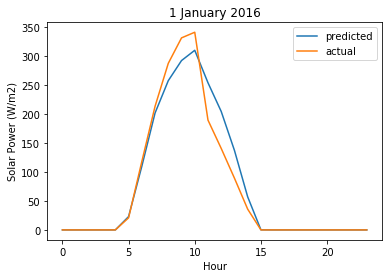

In [636]:
# user requests forecast for 1 January 2016 which we predict using data from 31 December 2015!
user_forecast_request = transformed_training_features[[-1], :]
user_forecast_response = random_forest_randomized_search.predict(user_forecast_request)[0]
actual_values_response = training_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("1 January 2016")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

# Assess model performance on testing data

In [675]:
testing_features = testing_data.drop("target(W/m2)", axis=1, inplace=False)
testing_target = testing_data.loc[:, ["target(W/m2)"]]
transformed_testing_features = preprocess_features(testing_features)

In [678]:
elastic_net_predictions = elastic_net_randomized_search.predict(testing_features)
np.sqrt(metrics.mean_squared_error(testing_target, elastic_net_predictions))

730.1968201547597

In [679]:
lasso_regression_predictions = lasso_regression_randomized_search.predict(testing_features)
np.sqrt(metrics.mean_squared_error(testing_target, lasso_regression_predictions))

1525.4387466231497

In [680]:
# random forest wins!
random_forest_predictions = random_forest_randomized_search.predict(testing_features)
np.sqrt(metrics.mean_squared_error(testing_target, random_forest_predictions))

52.821108713341516

Text(0.5, 0, 'Hours')

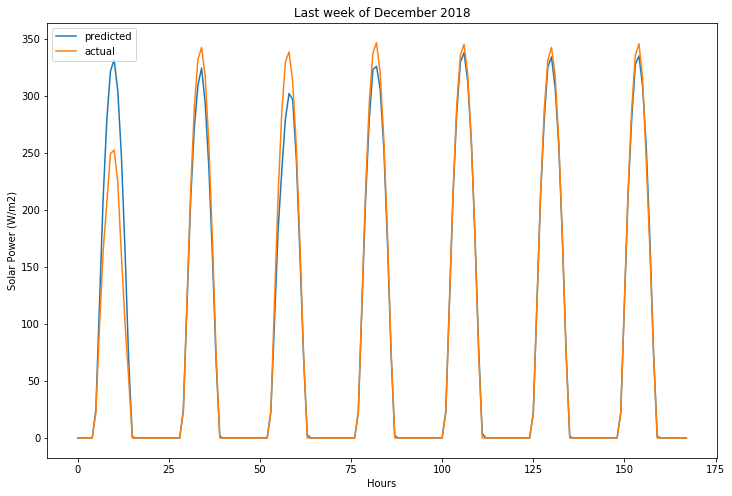

In [682]:
# user requests forecast for last week of 2018
user_forecast_request = transformed_testing_features[-7:, :]
user_forecast_response = random_forest_randomized_search.predict(user_forecast_request)
actual_values_response = testing_target.values[-7:, :]

# this would be rendered in Tableau!
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(user_forecast_response.flatten(), label="predicted")
ax.plot(actual_values_response.flatten(), label="actual")
ax.legend()
ax.set_title("Last week of December 2018")
ax.set_ylabel("Solar Power (W/m2)")
ax.set_xlabel("Hours")